In [1]:
# Core libraries
import torch
import numpy as np
import pandas as pd
import os
import re
from pathlib import Path
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Configure display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

print("✅ All libraries imported successfully!")
print(f"📦 PyTorch version: {torch.__version__}")
print(f"📦 NumPy version: {np.__version__}")
print(f"📦 Pandas version: {pd.__version__}")

✅ All libraries imported successfully!
📦 PyTorch version: 2.5.1
📦 NumPy version: 2.2.6
📦 Pandas version: 2.3.3


## 2. Define Loss Extraction Functions

Create robust functions to extract loss information from StreamSpeech checkpoint files.

In [2]:
def extract_loss_from_checkpoint(checkpoint_path):
    """
    Extract comprehensive loss information from a StreamSpeech checkpoint file.
    
    Args:
        checkpoint_path (str): Path to the checkpoint file
        
    Returns:
        dict: Dictionary containing extracted loss data and metadata
    """
    try:
        # Load checkpoint
        checkpoint = torch.load(checkpoint_path, map_location='cpu', weights_only=False)
        
        # Extract epoch number from filename
        filename = os.path.basename(checkpoint_path)
        epoch_match = re.search(r'checkpoint(\d+)\.pt', filename)
        if epoch_match:
            epoch = int(epoch_match.group(1))
        elif 'best' in filename:
            epoch = checkpoint.get('epoch', None)
        elif 'last' in filename:
            epoch = checkpoint.get('epoch', None)
        else:
            epoch = None

        # Get training state
        extra_state = checkpoint.get('extra_state', {})
        train_iterator = extra_state.get('train_iterator', {})
        
        # Initialize loss variables
        train_loss = None
        val_loss = None
        learning_rate = None
        
        # Extract validation loss from extra_state
        val_loss = extra_state.get('val_loss', None)
        if val_loss is not None:
            val_loss = float(val_loss)
        
        # Extract training loss from metrics
        metrics = extra_state.get('metrics', {})
        
        # Get training loss
        if 'train' in metrics:
            train_metrics = metrics['train']
            for metric in train_metrics:
                if len(metric) >= 3 and metric[1] == 'loss':
                    if 'val' in metric[3]:
                        train_loss_val = metric[3]['val']
                        if train_loss_val is not None:
                            if hasattr(train_loss_val, 'item'):  # tensor
                                train_loss = train_loss_val.item()
                            else:
                                train_loss = float(train_loss_val)
                    break
                elif len(metric) >= 3 and metric[1] == 'lr':
                    if 'val' in metric[3]:
                        lr_val = metric[3]['val']
                        if lr_val is not None:
                            learning_rate = float(lr_val)
        
        # Get validation loss from metrics if not found in extra_state
        if val_loss is None and 'valid' in metrics:
            valid_metrics = metrics['valid']
            for metric in valid_metrics:
                if len(metric) >= 3 and metric[1] == 'loss':
                    if 'val' in metric[3]:
                        val_loss_val = metric[3]['val']
                        if val_loss_val is not None:
                            if hasattr(val_loss_val, 'item'):
                                val_loss = val_loss_val.item()
                            else:
                                val_loss = float(val_loss_val)
                    break
        
        # Extract additional metrics
        multitask_losses = {}
        if 'train' in metrics:
            for metric in metrics['train']:
                if len(metric) >= 3:
                    metric_name = metric[1]
                    if 'multitask' in metric_name and 'val' in metric[3]:
                        val = metric[3]['val']
                        if val is not None:
                            if hasattr(val, 'item'):
                                multitask_losses[metric_name] = val.item()
                            else:
                                multitask_losses[metric_name] = float(val)
        
        return {
            'epoch': epoch,
            'train_loss': train_loss,
            'val_loss': val_loss,
            'learning_rate': learning_rate,
            'num_updates': train_iterator.get('total_iterations', 0),
            'iterations_in_epoch': train_iterator.get('iterations_in_epoch', 0),
            'multitask_losses': multitask_losses,
            'checkpoint_path': checkpoint_path,
            'file_size_mb': os.path.getsize(checkpoint_path) / (1024 * 1024)
        }
    
    except Exception as e:
        print(f"❌ Error processing {checkpoint_path}: {e}")
        return None

def get_checkpoint_sort_key(filepath):
    """Sort checkpoints by epoch number, handling special cases."""
    filename = os.path.basename(filepath)
    match = re.search(r'checkpoint(\d+)\.pt', filename)
    if match:
        return int(match.group(1))
    elif 'best' in filename:
        return 999999  # Put best checkpoint at the end
    elif 'last' in filename:
        return 999998  # Put last checkpoint near the end
    else:
        return 0  # Unknown format, put at the beginning

print("✅ Loss extraction functions defined successfully!")

✅ Loss extraction functions defined successfully!


## 3. Load and Process Checkpoint Data

Scan the checkpoint directory and extract loss information from all available checkpoints.

In [5]:
def create_plot(lang):
    # Define checkpoint directory
    checkpoint_dir = f"StreamSpeech/training/checkpoints/streamspeech.offline-s2st.{lang}"

    print(f"🔍 Scanning checkpoint directory: {checkpoint_dir}")

    # Find all checkpoint files
    checkpoint_files = []
    if os.path.exists(checkpoint_dir):
        for filename in os.listdir(checkpoint_dir):
            if filename.startswith('checkpoint') and filename.endswith('.pt'):
                checkpoint_files.append(os.path.join(checkpoint_dir, filename))
        
        # Sort by checkpoint number
        checkpoint_files.sort(key=get_checkpoint_sort_key)
        
        print(f"📁 Found {len(checkpoint_files)} checkpoint files")
        
        # Display checkpoint files
        # for i, file in enumerate(checkpoint_files):
        #     filename = os.path.basename(file)
        #     size_mb = os.path.getsize(file) / (1024 * 1024)
        #     print(f"  {i+1:2d}. {filename:<35} ({size_mb:.1f} MB)")
            
    else:
        print(f"❌ Checkpoint directory not found: {checkpoint_dir}")
        checkpoint_files = []

    # Extract loss data from all checkpoints
    print("🔄 Extracting loss data from checkpoints...")

    loss_data_list = []
    failed_files = []

    for i, checkpoint_path in enumerate(checkpoint_files):
        if "_" in checkpoint_path:
            continue
        filename = os.path.basename(checkpoint_path)
        print(f"  Processing {i+1:2d}/{len(checkpoint_files)}: {filename}")
        if (filename=="checkpoint_last.pt" or filename=="checkpoint_best.pt" or "1000" in filename):
            continue

        data = extract_loss_from_checkpoint(checkpoint_path)
        if data and data['epoch'] is not None:
            loss_data_list.append(data)
        else:
            failed_files.append(filename)
        

    print(f"\n✅ Successfully processed {len(loss_data_list)} checkpoints")
    if failed_files:
        print(f"❌ Failed to process: {failed_files}")

    # Convert to DataFrame for easier analysis
    if loss_data_list:
        df = pd.DataFrame(loss_data_list)
        
        # Display basic info
        print(f"\n📊 Data Summary:")
        print(f"  • Epochs covered: {df['epoch'].min()} - {df['epoch'].max()}")
        print(f"  • Training loss range: {df['train_loss'].min():.4f} - {df['train_loss'].max():.4f}")
        print(f"  • Validation loss range: {df['val_loss'].dropna().min():.4f} - {df['val_loss'].dropna().max():.4f}")
        print(f"  • Learning rate range: {df['learning_rate'].dropna().min():.6f} - {df['learning_rate'].dropna().max():.6f}")
        
        # Display first few rows
        print(f"\n📋 Sample Data:")
        display_cols = ['epoch', 'train_loss', 'val_loss', 'learning_rate', 'file_size_mb']
        print(df[display_cols].head(10).to_string(index=False, float_format='%.4f'))
        
    else:
        print("❌ No valid data extracted from checkpoints")
        df = pd.DataFrame()
# Create static matplotlib plots
    if not df.empty:
        
        # Set up the figure
        fig, axes = plt.subplots(1, 3, figsize=(18, 12))
        fig.suptitle(f'{lang} StreamSpeech Training Analysis', fontsize=16, fontweight='bold')
        
        # Prepare data
        train_df = df[df['train_loss'].notna()].copy()
        val_df = df[df['val_loss'].notna()].copy()
        
        # Plot 1: Training & Validation Loss vs Epochs
        ax1 = axes[0]
        if not train_df.empty:
            ax1.plot(train_df['epoch'], train_df['train_loss'], 'b-o', linewidth=2, 
                    markersize=4, label='Training Loss', alpha=0.8)
        # if not val_df.empty:
        #     ax1.plot(val_df['epoch'], val_df['val_loss'], 'r-o', linewidth=2, 
        #             markersize=4, label='Validation Loss', alpha=0.8)
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.set_title('Training & Validation Loss vs Epochs')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Plot 2: Training Loss Trend (smoothed)
        ax2 = axes[1]
        if not train_df.empty and len(train_df) > 3:
            window = min(5, len(train_df) // 3)
            smoothed_loss = train_df['train_loss'].rolling(window=window, center=True).mean()
            ax2.plot(train_df['epoch'], train_df['train_loss'], 'lightblue', 
                    alpha=0.5, linewidth=1, label='Original')
            ax2.plot(train_df['epoch'], smoothed_loss, 'darkblue', 
                    linewidth=3, label=f'Smoothed (window={window})')
            ax2.legend()
        elif not train_df.empty:
            ax2.plot(train_df['epoch'], train_df['train_loss'], 'b-o', 
                    linewidth=2, markersize=4)
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Training Loss')
        ax2.set_title('Training Loss Trend (Smoothed)')
        ax2.grid(True, alpha=0.3)
        
        # Plot 5: Loss Distribution
        ax5 = axes[2]
        if not train_df.empty:
            ax5.hist(train_df['train_loss'], bins=15, alpha=0.7, color='blue', edgecolor='black')
            ax5.axvline(train_df['train_loss'].mean(), color='red', linestyle='--', 
                    linewidth=2, label=f'Mean: {train_df["train_loss"].mean():.4f}')
            ax5.set_xlabel('Training Loss')
            ax5.set_ylabel('Frequency')
            ax5.set_title('Training Loss Distribution')
            ax5.legend()
            ax5.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
    else:
        print("❌ No data available for plotting")

🔍 Scanning checkpoint directory: StreamSpeech/training/checkpoints/streamspeech.offline-s2st.ma-en
📁 Found 7 checkpoint files
🔄 Extracting loss data from checkpoints...
  Processing  1/7: checkpoint5.pt
  Processing  2/7: checkpoint10.pt
  Processing  3/7: checkpoint15.pt
  Processing  4/7: checkpoint20.pt
  Processing  5/7: checkpoint25.pt

✅ Successfully processed 5 checkpoints

📊 Data Summary:
  • Epochs covered: 5 - 25
  • Training loss range: 21.1642 - 35.4178
  • Validation loss range: 22.7577 - 24.2435
  • Learning rate range: nan - nan

📋 Sample Data:
 epoch  train_loss  val_loss learning_rate  file_size_mb
     5     35.4178   23.2370          None      561.5124
    10     26.5290   22.7577          None      561.5124
    15     28.6880   23.2349          None      561.5124
    20     29.4095   22.9869          None      561.5124
    25     21.1642   24.2435          None      561.5124


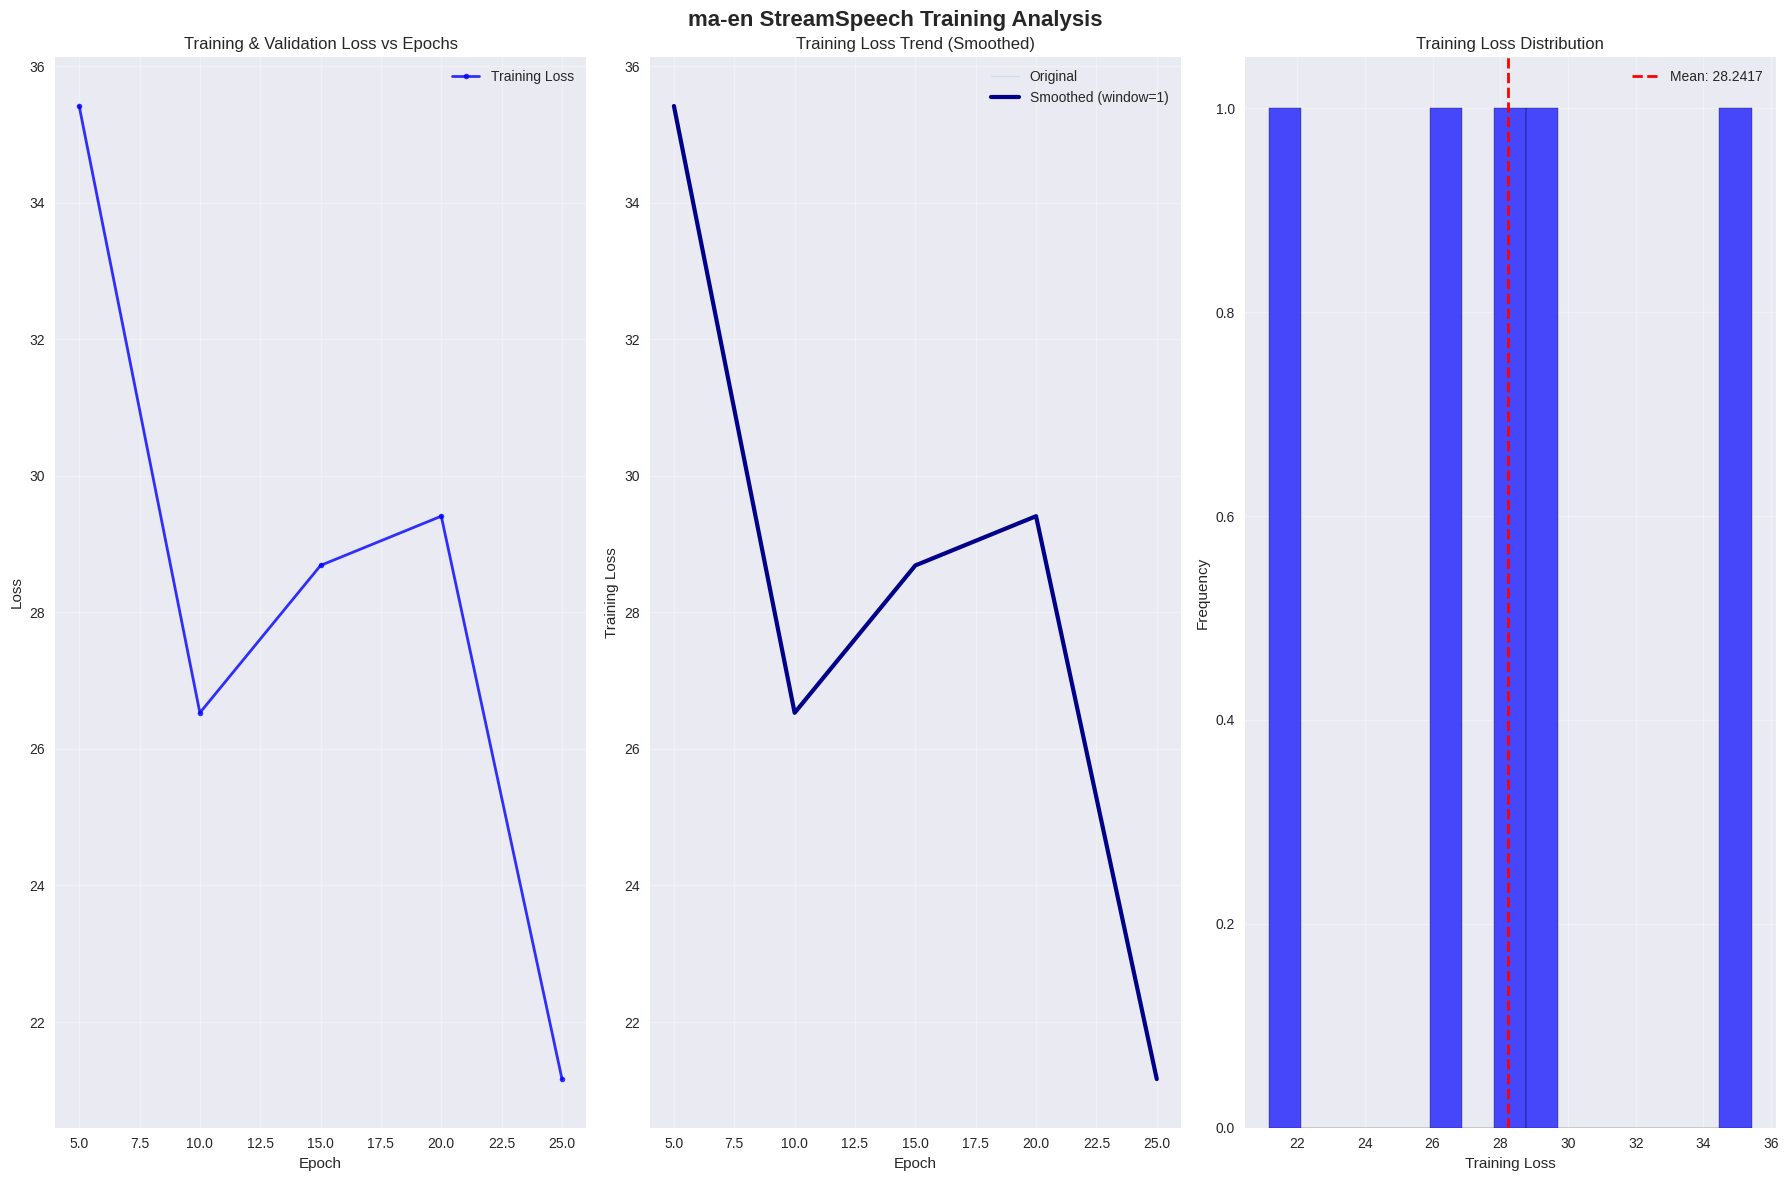

In [8]:
create_plot("ma-en")